#### Step 1 导入必要的库和定义全局变量

In [92]:
import os
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor

from nuplan.planning.training.preprocessing.features.trajectory_utils import convert_absolute_to_relative_poses

from nuplan.planning.training.preprocessing.utils.agents_preprocessing import (
	AgentInternalIndex,
	EgoInternalIndex,
	sampled_past_ego_states_to_tensor,
	sampled_past_timestamps_to_tensor,
	compute_yaw_rate_from_state_tensors,
	filter_agents_tensor,
	pack_agents_tensor,
	pad_agent_states
)

discrete_size = 10

past_time_horizon = 2

future_time_horizon = 8

# number of discrete traj
num_past_poses = discrete_size * past_time_horizon

# number of discrete trajectory points in future horizon
num_future_poses = discrete_size * future_time_horizon

# deal with top 20 closest agents around the ego vehicle
num_agents = 20

# [m] query radius scope relative to the current pose.
radius = 60

# Interpolation method to apply when interpolating to maintain fixed size map elements.
interpolation_method = 'linear'

# name of map features to be extracted.
map_features = [
	'LANE', 
	'ROUTE_LANES', 
	'CROSSWALK'
] 

# maximum number of elements to extract per feature layer.
max_elements = {
	'LANE': 40, 
	'ROUTE_LANES': 10, 
	'CROSSWALK': 5
}      
 
# maximum number of points per feature to extract per feature layer.
max_points = {
	'LANE': 50, 
	'ROUTE_LANES': 50, 
	'CROSSWALK': 30
}

# nuplan arguments
data_path = '/root/nuplan/dataset/nuplan-v1.1/splits/mini'
map_path = '/root/nuplan/dataset/maps'
save_path = '/root/workspace/GameFormer-Planner/ProcessedData'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False

map_version = "nuplan-maps-v1.0"    
sensor_root = None
db_files = None

# create folder for processed data
os.makedirs(save_path, exist_ok=True)

#### Step 2 获取 NuPlan 的场景信息

In [93]:
def get_filter_parameters(num_scenarios_per_type=20, limit_total_scenarios=None, shuffle=True):
	# nuplan challenge
	scenario_types = [
		'starting_left_turn',
		'starting_right_turn',
		'starting_straight_traffic_light_intersection_traversal',
		'stopping_with_lead',
		'high_lateral_acceleration',
		'high_magnitude_speed',
		'low_magnitude_speed',
		'traversing_pickup_dropoff',
		'waiting_for_pedestrian_to_cross',
		'behind_long_vehicle',
		'stationary_in_traffic',
		'near_multiple_vehicles',
		'changing_lane',
		'following_lane_with_lead',
	]

	scenario_tokens = None              # List of scenario tokens to include
	log_names = None                     # Filter scenarios by log names
	map_names = None                     # Filter scenarios by map names

	num_scenarios_per_type               # Number of scenarios per type
	limit_total_scenarios                # Limit total scenarios (float = fraction, int = num) - this filter can be applied on top of num_scenarios_per_type
	timestamp_threshold_s = None          # Filter scenarios to ensure scenarios have more than `timestamp_threshold_s` seconds between their initial lidar timestamps
	ego_displacement_minimum_m = None    # Whether to remove scenarios where the ego moves less than a certain amount

	expand_scenarios = False           # Whether to expand multi-sample scenarios to multiple single-sample scenarios
	remove_invalid_goals = True         # Whether to remove scenarios where the mission goal is invalid
	shuffle                             # Whether to shuffle the scenarios

	ego_start_speed_threshold = None     # Limit to scenarios where the ego reaches a certain speed from below
	ego_stop_speed_threshold = None      # Limit to scenarios where the ego reaches a certain speed from above
	speed_noise_tolerance = None         # Value at or below which a speed change between two timepoints should be ignored as noise.

	return scenario_types, scenario_tokens, log_names, map_names, num_scenarios_per_type, limit_total_scenarios, timestamp_threshold_s, ego_displacement_minimum_m, \
		   expand_scenarios, remove_invalid_goals, shuffle, ego_start_speed_threshold, ego_stop_speed_threshold, speed_noise_tolerance

def get_scenario_map():
	scenario_map = {
		'accelerating_at_crosswalk': [15.0, -3.0],
		'accelerating_at_stop_sign': [15.0, -3.0],
		'accelerating_at_stop_sign_no_crosswalk': [15.0, -3.0],
		'accelerating_at_traffic_light': [15.0, -3.0],
		'accelerating_at_traffic_light_with_lead': [15.0, -3.0],
		'accelerating_at_traffic_light_without_lead': [15.0, -3.0],
		'behind_bike': [15.0, -3.0],
		'behind_long_vehicle': [15.0, -3.0],
		'behind_pedestrian_on_driveable': [15.0, -3.0],
		'behind_pedestrian_on_pickup_dropoff': [15.0, -3.0],
		'changing_lane': [15.0, -3.0],
		'changing_lane_to_left': [15.0, -3.0],
		'changing_lane_to_right': [15.0, -3.0],
		'changing_lane_with_lead': [15.0, -3.0],
		'changing_lane_with_trail': [15.0, -3.0],
		'crossed_by_bike': [15.0, -3.0],
		'crossed_by_vehicle': [15.0, -3.0],
		'following_lane_with_lead': [15.0, -3.0],
		'following_lane_with_slow_lead': [15.0, -3.0],
		'following_lane_without_lead': [15.0, -3.0],
		'high_lateral_acceleration': [15.0, -3.0],
		'high_magnitude_jerk': [15.0, -3.0],
		'high_magnitude_speed': [15.0, -3.0],
		'low_magnitude_speed': [15.0, -3.0],
		'medium_magnitude_speed': [15.0, -3.0],
		'near_barrier_on_driveable': [15.0, -3.0],
		'near_construction_zone_sign': [15.0, -3.0],
		'near_high_speed_vehicle': [15.0, -3.0],
		'near_long_vehicle': [15.0, -3.0],
		'near_multiple_bikes': [15.0, -3.0],
		'near_multiple_pedestrians': [15.0, -3.0],
		'near_multiple_vehicles': [15.0, -3.0],
		'near_pedestrian_at_pickup_dropoff': [15.0, -3.0],
		'near_pedestrian_on_crosswalk': [15.0, -3.0],
		'near_pedestrian_on_crosswalk_with_ego': [15.0, -3.0],
		'near_trafficcone_on_driveable': [15.0, -3.0],
		'on_all_way_stop_intersection': [15.0, -3.0],
		'on_carpark': [15.0, -3.0],
		'on_intersection': [15.0, -3.0],
		'on_pickup_dropoff': [15.0, -3.0],
		'on_stopline_crosswalk': [15.0, -3.0],
		'on_stopline_stop_sign': [15.0, -3.0],
		'on_stopline_traffic_light': [15.0, -3.0],
		'on_traffic_light_intersection': [15.0, -3.0],
		'starting_high_speed_turn': [15.0, -3.0],
		'starting_left_turn': [15.0, -3.0],
		'starting_low_speed_turn': [15.0, -3.0],
		'starting_protected_cross_turn': [15.0, -3.0],
		'starting_protected_noncross_turn': [15.0, -3.0],
		'starting_right_turn': [15.0, -3.0],
		'starting_straight_stop_sign_intersection_traversal': [15.0, -3.0],
		'starting_straight_traffic_light_intersection_traversal': [15.0, -3.0],
		'starting_u_turn': [15.0, -3.0],
		'starting_unprotected_cross_turn': [15.0, -3.0],
		'starting_unprotected_noncross_turn': [15.0, -3.0],
		'stationary': [15.0, -3.0],
		'stationary_at_crosswalk': [15.0, -3.0],
		'stationary_at_traffic_light_with_lead': [15.0, -3.0],
		'stationary_at_traffic_light_without_lead': [15.0, -3.0],
		'stationary_in_traffic': [15.0, -3.0],
		'stopping_at_crosswalk': [15.0, -3.0],
		'stopping_at_stop_sign_no_crosswalk': [15.0, -3.0],
		'stopping_at_stop_sign_with_lead': [15.0, -3.0],
		'stopping_at_stop_sign_without_lead': [15.0, -3.0],
		'stopping_at_traffic_light_with_lead': [15.0, -3.0],
		'stopping_at_traffic_light_without_lead': [15.0, -3.0],
		'stopping_with_lead': [15.0, -3.0],
		'traversing_crosswalk': [15.0, -3.0],
		'traversing_intersection': [15.0, -3.0],
		'traversing_narrow_lane': [15.0, -3.0],
		'traversing_pickup_dropoff': [15.0, -3.0],
		'traversing_traffic_light_intersection': [15.0, -3.0],
		'waiting_for_pedestrian_to_cross': [15.0, -3.0]
	}

	return scenario_map

scenario_mapping = ScenarioMapping(
	scenario_map=get_scenario_map(), 
	subsample_ratio_override=0.5
)

builder = NuPlanScenarioBuilder(
	data_path, 
	map_path, 
	sensor_root, 
	db_files, 
	map_version, 
	scenario_mapping=scenario_mapping
)

# scenarios for training
scenario_filter = ScenarioFilter(
	*get_filter_parameters(
		scenarios_per_type, 
		total_scenarios, 
		shuffle_scenarios
	)
)

# enable parallel process
worker = SingleMachineParallelExecutor(use_process_pool=True)

# get scenarios
scenarios = builder.get_scenarios(scenario_filter, worker)

# delete useless variables, only deal with scenarios
del worker, builder, scenario_filter, scenario_mapping

#### Step 3 挑选一个场景，然后开始处理数据

In [94]:
# get scenario info
scenario = scenarios[100]
map_name = scenario._map_name
token    = scenario.token

# get map api
map_api  = scenario.map_api

##### 3.1 先处理历史信息

In [114]:
from nuplan.planning.training.preprocessing.feature_builders.vector_builder_utils import (
    MapObjectPolylines,
	LaneSegmentTrafficLightData,
	VectorFeatureLayer, 
 	VectorFeatureLayerMapping,
	get_lane_polylines,
	get_traffic_light_encoding,
 	get_route_lane_polylines_from_roadblock_ids,
	get_map_object_polygons
)

from nuplan.common.maps.maps_datatypes import TrafficLightStatusData
from nuplan.common.actor_state.state_representation import Point2D, StateSE2
from nuplan.common.maps.abstract_map import AbstractMap

from typing import List, Dict, Tuple

def get_neighbor_vector_set_map(
    map_api: AbstractMap,
    map_features: List[str],
    point: Point2D,
    radius: float,
    route_roadblock_ids: List[str],
    traffic_light_status_data: List[TrafficLightStatusData],
) -> Tuple[Dict[str, MapObjectPolylines], Dict[str, LaneSegmentTrafficLightData]]:
    """
    Extract neighbor vector set map information around ego vehicle.
    :param map_api: map to perform extraction on.
    :param map_features: Name of map features to extract.
    :param point: [m] x, y coordinates in global frame.
    :param radius: [m] floating number about vector map query range.
    :param route_roadblock_ids: List of ids of roadblocks/roadblock connectors (lane groups) within goal route.
    :param traffic_light_status_data: A list of all available data at the current time step.
    :return:
        coords: Dictionary mapping feature name to polyline vector sets.
        traffic_light_data: Dictionary mapping feature name to traffic light info corresponding to map elements
            in coords.
    :raise ValueError: if provided feature_name is not a valid VectorFeatureLayer.
    """
    coords: Dict[str, MapObjectPolylines] = {}
    traffic_light_data: Dict[str, LaneSegmentTrafficLightData] = {}
    feature_layers: List[VectorFeatureLayer] = []

    for feature_name in map_features:
        try:
            feature_layers.append(VectorFeatureLayer[feature_name])
        except KeyError:
            raise ValueError(f"Object representation for layer: {feature_name} is unavailable")

    # extract lanes
    if VectorFeatureLayer.LANE in feature_layers:
        lanes_mid, lanes_left, lanes_right, lane_ids = get_lane_polylines(map_api, point, radius)

        # lane baseline paths
        coords[VectorFeatureLayer.LANE.name] = lanes_mid

        # lane traffic light data
        traffic_light_data[VectorFeatureLayer.LANE.name] = get_traffic_light_encoding(
            lane_ids, traffic_light_status_data
        )

        # lane boundaries
        if VectorFeatureLayer.LEFT_BOUNDARY in feature_layers:
            coords[VectorFeatureLayer.LEFT_BOUNDARY.name] = MapObjectPolylines(lanes_left.polylines)
        if VectorFeatureLayer.RIGHT_BOUNDARY in feature_layers:
            coords[VectorFeatureLayer.RIGHT_BOUNDARY.name] = MapObjectPolylines(lanes_right.polylines)

    # extract route
    if VectorFeatureLayer.ROUTE_LANES in feature_layers:
        route_polylines = get_route_lane_polylines_from_roadblock_ids(map_api, point, radius, route_roadblock_ids)
        coords[VectorFeatureLayer.ROUTE_LANES.name] = route_polylines

    # extract generic map objects
    for feature_layer in feature_layers:
        if feature_layer in VectorFeatureLayerMapping.available_polygon_layers():
            polygons = get_map_object_polygons(
                map_api, point, radius, VectorFeatureLayerMapping.semantic_map_layer(feature_layer)
            )
            coords[feature_layer.name] = polygons

    return coords, traffic_light_data

In [118]:
class DataProcessor:
	def __init__(self, scenario):
		# map api
		self.scenario = scenario
		
		# discrete 1 second to several points
		self.discrete_size = 10

		# history observation horizon
		self.past_time_horizon = 2

		# prediction horizon
		self.future_time_horizon = 8

		# number of discrete trajectory points
		self.num_past_poses = self.discrete_size * self.past_time_horizon

		# number of discrete trajectory points in future horizon
		self.num_future_poses = self.discrete_size * self.future_time_horizon

		# deal with top 20 closest agents around the ego vehicle
		self.num_agents = 20

		# [m] query radius scope relative to the current pose.
		self.query_radius = 60

		# Interpolation method to apply when interpolating to maintain fixed size map elements.
		self.interpolation_method = 'linear'

		# name of map features to be extracted.
		self.map_features = [
			'LANE', 
			'ROUTE_LANES', 
			'CROSSWALK'
		] 

		# maximum number of elements to extract per feature layer.
		self.max_elements = {
			'LANE': 40, 
			'ROUTE_LANES': 10, 
			'CROSSWALK': 5
		}      
		
		# maximum number of points per feature to extract per feature layer.
		self.max_points = {
			'LANE': 50, 
			'ROUTE_LANES': 50, 
			'CROSSWALK': 30
		}

		# initial state of ego vehicle
		self.anchor_ego_state = self.scenario.initial_ego_state
  
		# map related
		self.map_name = self.scenario._map_name
		self.map_api = scenario.map_api

	def process_ego_info(self):
		pass

	def process_agent_info(self):
		pass

	def process_map_info(self):
		ego_coords = Point2D(
      		self.anchor_ego_state.rear_axle.x, 
        	self.anchor_ego_state.rear_axle.y
        )

		route_roadblock_ids = self.scenario.get_route_roadblock_ids()
		traffic_light_data = self.scenario.get_traffic_light_status_at_iteration(0)
		
		coords, traffic_light_data = get_neighbor_vector_set_map(
			self.map_api,
			self.map_features, 
			ego_coords,
			self.query_radius,
			route_roadblock_ids,
			traffic_light_data
		)
  
		print(coords)
		print(traffic_light_data)
  
	def plot_vector_map(self):
		pass

	def plot_agents(self):
		pass

	def plot_ego(self):
		pass

data_processor = DataProcessor(scenario)
data_processor.process_map_info()

{'LANE': MapObjectPolylines(polylines=[[Point2D(x=664434.7140139048, y=3997233.5744942976), Point2D(x=664434.7185270047, y=3997233.3245350374), Point2D(x=664434.7231025933, y=3997233.074576914), Point2D(x=664434.7277406702, y=3997232.824619942), Point2D(x=664434.7324412374, y=3997232.574664137), Point2D(x=664434.7372042947, y=3997232.324709515), Point2D(x=664434.7420298393, y=3997232.0747560915), Point2D(x=664434.7469178734, y=3997231.8248038827), Point2D(x=664434.7518683944, y=3997231.574852905), Point2D(x=664434.756881402, y=3997231.3249031696), Point2D(x=664434.7619568981, y=3997231.0749546974), Point2D(x=664434.7670948827, y=3997230.8250075006), Point2D(x=664434.7722953528, y=3997230.575061598), Point2D(x=664434.7775583084, y=3997230.325117003), Point2D(x=664434.7828837514, y=3997230.075173731), Point2D(x=664434.7882716793, y=3997229.8252317985), Point2D(x=664434.7937220918, y=3997229.575291219), Point2D(x=664434.799234991, y=3997229.3253520103), Point2D(x=664434.804810374, y=39972

**3.1.1** Ego 的历史信息

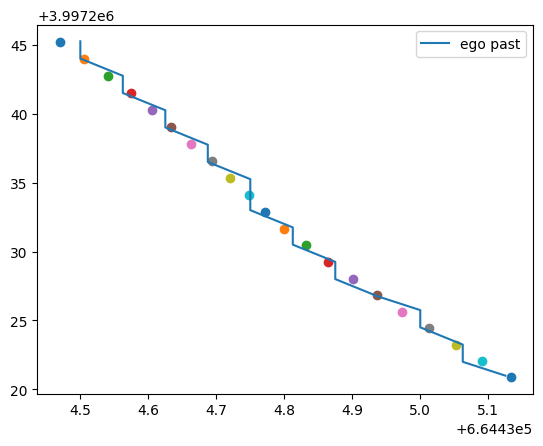

In [100]:
# get ego query state
query_ego_state = scenario.initial_ego_state

# get past ego states in past_time_horizon
past_ego_states = scenario.get_ego_past_trajectory(
	iteration=0,
	num_samples=num_past_poses,
	time_horizon=past_time_horizon
)

# include current state
sampled_past_ego_states = list(past_ego_states) + [query_ego_state]

# convert ego_state list to tensor
past_ego_states_tensor = sampled_past_ego_states_to_tensor(sampled_past_ego_states)

# get observation time
current_ego_timestamp = scenario.start_time

# get history timestamps
past_ego_timestamps = scenario.get_past_timestamps(
		iteration=0,
  		num_samples=num_past_poses,
		time_horizon=past_time_horizon
)

# include current timestamp
sampled_past_ego_timestamps = list(past_ego_timestamps) + [current_ego_timestamp]

# plot
plt.plot(past_ego_states_tensor[:, EgoInternalIndex.x()], 
		 past_ego_states_tensor[:, EgoInternalIndex.y()], 
		 label='ego past')
plt.legend()

for state in sampled_past_ego_states:
	plt.scatter(state.rear_axle.x, state.rear_axle.y)

**3.1.2** Agent 的历史信息

In [96]:
from nuplan.database.nuplan_db.nuplan_scenario_queries import *

# Find surrounding agents
current_tracked_objects = scenario.initial_tracked_objects.tracked_objects

past_tracked_objects = [
	tracked_objects.tracked_objects
	for tracked_objects in scenario.get_past_tracked_objects(
		iteration=0,
		time_horizon=past_time_horizon,
		num_samples=num_past_poses
	)
]  

sampled_past_observations = past_tracked_objects + [current_tracked_objects]

object_types = [
	TrackedObjectType.VEHICLE, 
	TrackedObjectType.PEDESTRIAN, 
	TrackedObjectType.BICYCLE
]

past_tracked_objects_tensor_list = []
past_tracked_objects_types = []
track_token_ids = {}

for i in range(len(sampled_past_observations)):
	agents = sampled_past_observations[i].get_tracked_objects_of_types(object_types)
	agent_types = []

	output = torch.zeros(
		(len(agents), AgentInternalIndex.dim()),
		dtype=torch.float32
	)

	max_agent_id = len(track_token_ids)
	
	for idx, agent in enumerate(agents):
		if agent.track_token not in track_token_ids:
			track_token_ids[agent.track_token] = max_agent_id
			max_agent_id += 1
   
		track_token_int = track_token_ids[agent.track_token]
  		
		output[idx, AgentInternalIndex.track_token()] = float(track_token_int)
		output[idx, AgentInternalIndex.vx()] = agent.velocity.x
		output[idx, AgentInternalIndex.vy()] = agent.velocity.y
		output[idx, AgentInternalIndex.heading()] = agent.center.heading
		output[idx, AgentInternalIndex.width()] = agent.box.width
		output[idx, AgentInternalIndex.length()] = agent.box.length
		output[idx, AgentInternalIndex.x()] = agent.center.x
		output[idx, AgentInternalIndex.y()] = agent.center.y
		
		agent_types.append(agent.tracked_object_type)
  
	past_tracked_objects_tensor_list.append(output)
	past_tracked_objects_types.append(agent_types)

**3.1.3** Agent Past Process

tensor([[ 0.0000e+00,  1.3243e-01, -9.2967e+00, -1.5502e+00,  1.9216e+00,
          4.7275e+00,  6.6443e+05,  3.9972e+06],
        [ 1.0000e+00,  3.3153e-01, -1.0459e+01, -1.5415e+00,  2.2430e+00,
          6.1873e+00,  6.6443e+05,  3.9973e+06],
        [ 2.0000e+00,  2.1370e-01, -8.6365e+00, -1.5413e+00,  1.9047e+00,
          4.5827e+00,  6.6443e+05,  3.9972e+06],
        [ 3.0000e+00,  2.6497e-01, -1.6151e+01, -1.5552e+00,  2.2487e+00,
          5.2494e+00,  6.6444e+05,  3.9972e+06],
        [ 4.0000e+00,  2.7254e-01, -1.3503e+01, -1.5452e+00,  2.1673e+00,
          4.8985e+00,  6.6444e+05,  3.9972e+06],
        [ 5.0000e+00,  4.2963e-01, -1.3802e+01, -1.5405e+00,  1.9506e+00,
          4.6837e+00,  6.6444e+05,  3.9973e+06],
        [ 6.0000e+00,  5.4287e-01, -1.0756e+01, -1.5187e+00,  1.9141e+00,
          4.7602e+00,  6.6444e+05,  3.9973e+06],
        [ 7.0000e+00,  5.5656e-01, -1.7550e+01, -1.5355e+00,  1.9879e+00,
          5.7317e+00,  6.6444e+05,  3.9973e+06],
        [ 8.0000

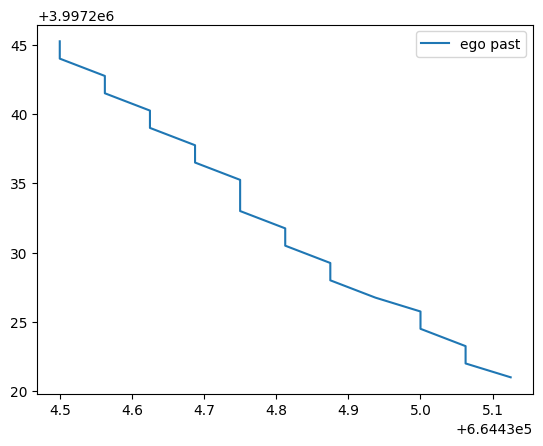

In [110]:
def validate_agent_internal_shape(feature: torch.Tensor) -> None:
	"""
	Validates the shape of the provided tensor if it's expected to be an AgentInternal.
	:param feature: the tensor to validate.
	"""
	if len(feature.shape) != 2 or feature.shape[1] != AgentInternalIndex.dim():
		raise ValueError(f"Improper agent internal shape: {feature.shape}")
	
from nuplan.planning.training.preprocessing.features.agents import Agents
from nuplan.common.geometry.torch_geometry import global_state_se2_tensor_to_local

# get state dimensions
agents_states_dim = Agents.agents_states_dim()

# 注：这里为了和原函数保持一致，还没有进行 global -> local 的转换
ego_history = past_ego_states_tensor.clone()

plt.plot(past_ego_states_tensor[:, EgoInternalIndex.x()], 
		 past_ego_states_tensor[:, EgoInternalIndex.y()], 
		 label='ego past')
plt.legend()

# get timestamps
timestamps = sampled_past_ego_timestamps

# get agent history
agents = past_tracked_objects_tensor_list

# get query point
anchor_ego_state = ego_history[-1, :].squeeze().clone()

# convert absolute quantities to relative quantities
ego_pose = torch.tensor(
	[
		float(anchor_ego_state[EgoInternalIndex.x()].item()),
		float(anchor_ego_state[EgoInternalIndex.y()].item()),
		float(anchor_ego_state[EgoInternalIndex.heading()].item()),
	],
	dtype=torch.float64,
)

agent_global_poses = ego_history[
	:, 
	[
		EgoInternalIndex.x(), 
		EgoInternalIndex.y(), 
		EgoInternalIndex.heading()
	]
]

transformed_poses = global_state_se2_tensor_to_local(
	agent_global_poses, 
 	ego_pose, 
  	precision=torch.float64
)

ego_history[:, EgoInternalIndex.x()] = transformed_poses[:, 0].float()
ego_history[:, EgoInternalIndex.y()] = transformed_poses[:, 1].float()
ego_history[:, EgoInternalIndex.heading()] = transformed_poses[:, 2].float()

agent_types = past_tracked_objects_types[-1]

agent_history = agents
target_tensor = agent_history[-1]
for i in range(len(agent_history)):
	validate_agent_internal_shape(agent_history[i])
	
	rows: List[torch.Tensor] = []
	for j in range(agent_history[i].shape[0]):
		if target_tensor.shape[0] > 0:
			agent_id = float(agent_history[i][j, int(AgentInternalIndex.track_token())].item())
			is_in_target_frame = bool(
				(agent_id == target_tensor[:, AgentInternalIndex.track_token()]).max().item()
			)
			if is_in_target_frame:
				rows.append(agent_history[i][j, :].squeeze())
				
	if len(rows) > 0:
		agent_history[i] = torch.stack(rows)
	else:
		agent_history[i] = torch.empty((0, agents[i].shape[1]), dtype=torch.float32)

agent_types = past_tracked_objects_types[-1]

